In [1]:
# Dependencies
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modules.words import load_data, extraction
from modules.hashtags import show_counts, filter_dataset, splitter

%matplotlib inline

[nltk_data] Downloading package wordnet to /home/domenico/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/domenico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Hashatag analysis

### Whole dataset

In [2]:
tweets_all = { 2018 : pd.read_json('./data/tweets_preGreta.json',
                                    dtype = { 'id': np.unicode_}),
               2019 : pd.read_json('./data/tweets_postGreta.json',
                                    dtype = { 'id': np.unicode_})
             }

In [3]:
# inputs: dataframes, words on which filter
show_counts(tweets_all, [])

hashtag frequencies in 2018: 

 {'climatechange': 8841, 'climatecrisis': 36, 'parisagreement': 1130, 'gretathunberg': 0, 'climatestrike': 0, 'fridays4future': 0}

hashtag frequencies in 2019: 

 {'climatechange': 6411, 'climatecrisis': 831, 'parisagreement': 202, 'gretathunberg': 146, 'climatestrike': 1645, 'fridays4future': 65}



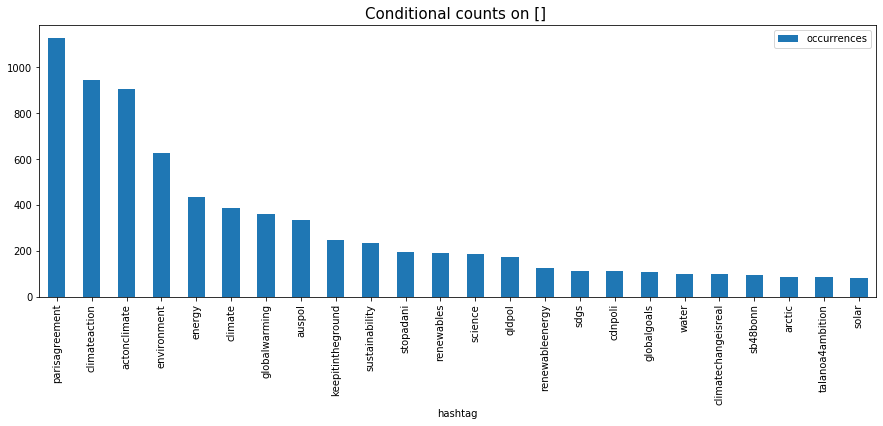

In [4]:
top_hash_pre = filter_dataset(tweets_all[2018], year=2018, words=[], n_max=25, n_min=1)

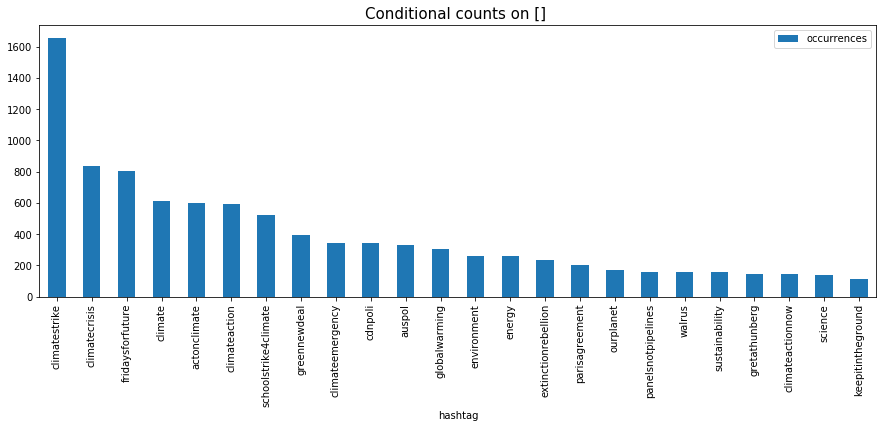

In [5]:
top_hash_post = filter_dataset(tweets_all[2019], year=2019, words=[], n_max=25, n_min=1)

### ClimateChange dataset

In [6]:
# unique dataset with all periods
tweets = load_data()

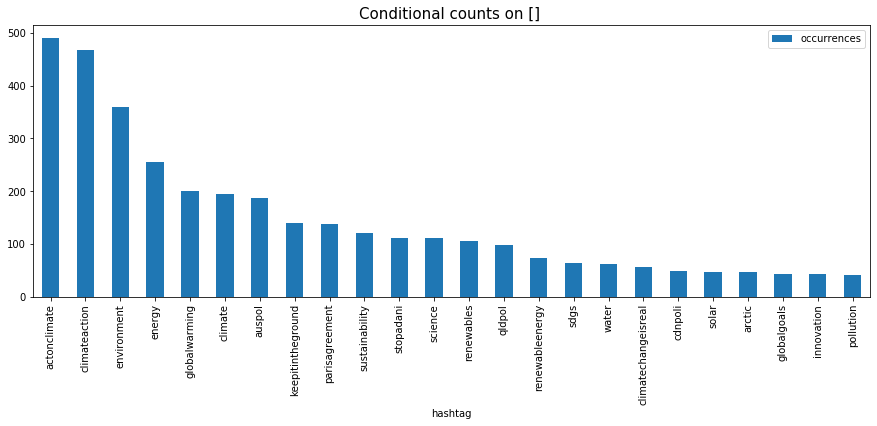

In [7]:
hash_pre_climate = filter_dataset(tweets, year=2018, words=[], n_max=25, n_min=1)

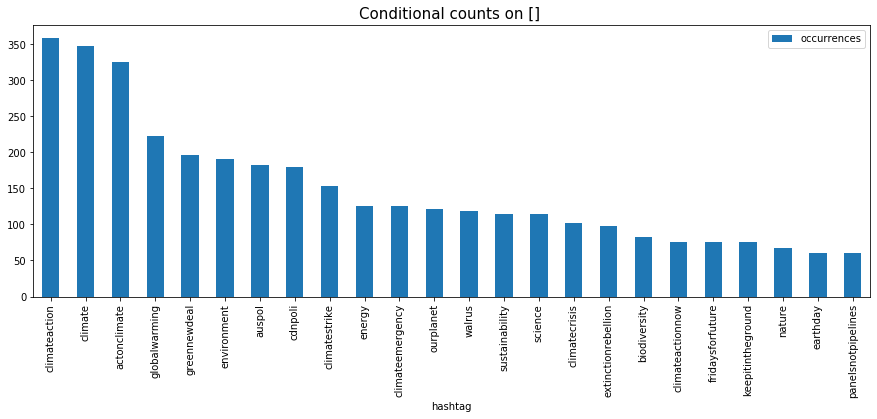

In [8]:
hash_post_climate = filter_dataset(tweets, year=2019, words=[], n_max=25, n_min=1)

In [38]:
hash_pre_climate.head()

,hashtag,occurrences
1,climatechange,5035
65,actonclimate,491
3,climateaction,467
51,environment,360
114,energy,256


### Split hashtags

In [39]:
splitted = splitter(hash_pre_climate, hash_post_climate, save = True)
splitted.head()

/home/domenico/GitHub/ClimateAction/modules/hashtags.py:125: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.np.nan,


                  word                       proposed_splitting  count_pre  \
0       extremeweather                   ['extreme', 'weather']         15   
1  makeyourownseastead  ['make', 'your', 'own', 'sea', 'stead']          2   
2          tideturning                      ['tide', 'turning']          1   
3         earthwarrior                     ['earth', 'warrior']          1   
4            pregnancy                                      NaN          3   

   count_post  
0        18.0  
1         NaN  
2         1.0  
3         NaN  
4         NaN  


,word,proposed_splitting,count_pre,count_post
0,extremeweather,"['extreme', 'weather']",15,18.0
1,makeyourownseastead,"['make', 'your', 'own', 'sea', 'stead']",2,NaN
2,tideturning,"['tide', 'turning']",1,1.0
3,earthwarrior,"['earth', 'warrior']",1,NaN
4,pregnancy,NaN,3,NaN


### Select most frequent hashtag to be splitted manually

In [40]:
# Join top_hash pre and post
top_hash = hash_pre_climate.set_index("hashtag").join(hash_post_climate.set_index("hashtag"), how="outer", lsuffix="pre", rsuffix="post")
# Remove nans and sum occurrences
top_hash[top_hash.isna()] = 0
top_hash["occurrences_tot"] = top_hash.occurrencespre + top_hash.occurrencespost
# Select top 400 frequent values
top_hash = top_hash.sort_values(by="occurrences_tot", ascending=False)[:400]

In [43]:
top_splitted = splitted.join(top_hash, on="word", how="right")
top_splitted = top_splitted.sort_values(by="occurrences_tot", ascending=False)
top_splitted[["word", "proposed_splitting", "count_pre", "count_post"]]#.to_csv("top_400_hashtags_raw.tsv", sep='\t')

,word,proposed_splitting,count_pre,count_post
1005,climatechange,"['climate', 'change']",5035,5030.0
4493,climateaction,"['climate', 'action']",467,359.0
750,actonclimate,NaN,491,325.0
4090,environment,NaN,360,191.0
4328,climate,NaN,194,348.0
...,...,...,...,...
3162,foodwaste,"['food', 'waste']",3,5.0
1101,montreal,NaN,8,NaN
6031,vanpoli,NaN,4,4.0
3679,alarmism,"['alarm', 'is', 'm']",8,NaN


Once the dataframe has been manually corrected, it can be loaded and converted into a dictionary

In [69]:
import pickle

def save_splitting(row, split_dict):
    """
    Save the proposed splitting in a dictionary
    """
    word = row.word
    splitting = row.proposed_splitting
    
    # For all the word for which exists a proposed splitting
    if splitting:
        # Remove all the useless characters
        for character in ['[', ']', "'"]:
            splitting = splitting.replace(character, '')
        # Split the string in words
        splitting = splitting.split(', ')
    # If there is no suggested splitting, the original word is kept
    else:
        splitting = [word]
        
    split_dict[word] = splitting



# Load the dataset and use None to identify all null values
top_splitted = pd.read_csv("top_400_hashtags.tsv", sep='\t').iloc[:,:2]
top_splitted[top_splitted.isnull()] = None

# Initialize dictionary to store suggested splitting
split_dict = {}
# Format each string and save the resulting splitting in the dictionary
top_splitted.apply(save_splitting, split_dict=split_dict, axis=1)

# Save the dictionary
with open('splitting_dict.txt', 'wb') as infile:
    pickle.dump(split_dict, infile)

## Dataset creation

Once the words are extracted, they are stored in a Pandas DataFrame with the following attributes:

1. <code> id </code> : Reference to the tweet ID
2. <code> index </code> : Position of the word in the sentence (tweet) - useful to delete self loops
3. <code> text </code> : Actual word
4. <code> pos </code> : Part Of Speech tag
5. <code> conf </code> : Confidence associated to the POS tag

In [ ]:
extraction(tweets, 0.95)